In [64]:
%%time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
%matplotlib inline


df = pd.read_csv('IDAO 2020/train.csv')
df['epoch'] = pd.to_datetime(df.pop('epoch'))
df.index = df['epoch']
df.index = df.index.round('1min')
df['epoch'] = df.index

def get_df_smape_score(sat_id_list, y_pred, y_test):
    if isinstance(sat_id_list, np.ndarray):
        sat_id_list = sat_id_list.tolist()

    reversed_sat_id_list = sat_id_list[::-1]
    smape_scores = []
    sats_smape_scores = []
    for sat_id in sorted(set(sat_id_list)):
        a = sat_id_list.index(sat_id)
        b = len(sat_id_list) - reversed_sat_id_list.index(sat_id)  # dirty hack
        sat_train_vals = y_pred[a:b]
        sat_test_vals = y_test[a:b]
        sat_smape_score = np.mean([smape(sat_train_vals[:, i], sat_test_vals[:, i]) for i in range(6)])
        #         print('sat_id, a, b, smape', sat_id, a, b, sat_smape_score)
        sats_smape_scores.append(dict(sat_id=sat_id,
                                      a=b,
                                      b=b,
                                      sat_smape_score=sat_smape_score,
                                      rows=len(sat_train_vals)))
        smape_scores.append(sat_smape_score)
    mean_smape_score = np.mean(smape_scores)
    score = 100 * (1 - mean_smape_score)

    df_sats_smapes = pd.DataFrame(sats_smape_scores)
    return score, df_sats_smapes


def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

def get_df_stats(df):
    if 'Vx' in df.columns:
        Vx_col, Vy_col, Vz_col = 'Vx', 'Vy', 'Vz'
    elif 'Vx_sim' in df.columns:
        Vx_col, Vy_col, Vz_col = 'Vx_sim', 'Vy_sim', 'Vz_sim'
        
    stat_lines = []
    for sat_id, df_sat in df.groupby('sat_id'):
        sat_stats=dict(sat_id=sat_id,
                       start=df_sat['epoch'].min(), 
                       end=df_sat['epoch'].max(),
                       n_points=len(df_sat),
                       Vx_mean=df_sat[Vx_col].mean(),
                       Vy_mean=df_sat[Vy_col].mean(),
                       Vz_mean=df_sat[Vz_col].mean()
        )
        stat_lines.append(sat_stats)
    df_stats = pd.DataFrame(stat_lines)
    return df_stats

test_data = pd.read_csv('IDAO 2020/Track 1/test.csv')
test_data['epoch'] = pd.to_datetime(test_data['epoch'])
test_subm = pd.read_csv('IDAO 2020/Track 1/submission.csv')


df_stats = get_df_stats(df)
df_stats_test = get_df_stats(test_data)

X_lines = []
y_lines = []
smape_scores = []
sat_id_list = []
for sat_id, df_sat in df.groupby('sat_id'):
    df_sat.index = df_sat['epoch']
    df_sat1 = df_sat[:pd.to_datetime('2014-01-15 23:59:59.999')]
    df_sat2 = df_sat['2014-01-16 00:00:00':]
    if df_sat2.__len__() > df_sat1.__len__():
        df_sat2 = df_sat2.head(df_sat1.__len__())
    else:
        raise Exception('wrong len')
    
    sat_train_vals = df_sat1[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].values
    sat_test_vals = df_sat2[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].values
    
    sat_smape_score = [smape(sat_train_vals[:, i], sat_test_vals[:, i]) for i in range(6)]
    smape_scores.append(sat_smape_score)
    
    X_lines.extend(sat_train_vals.tolist())
    y_lines.extend(sat_test_vals.tolist())
    sat_id_list.extend([sat_id]*len(sat_train_vals))


X = np.array(X_lines)
y = np.array(y_lines)
sat_id_list = np.array(sat_id_list)

mean_smape_score = np.mean(smape_scores)
print('mean_smape_score', mean_smape_score)
#    
#     score = smape(X_test[i], y_test[i])
X_train, X_test, y_train, y_test, sat_id_list_train, sat_id_test = train_test_split(X, y, sat_id_list, shuffle=False)
print('shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape, sat_id_list_train.shape, sat_id_test.shape)

def get_df_simple_smape_score(y_pred, y_test):
    sat_smape_score = [smape(y_pred[:, i], y_test[:, i]) for i in range(6)]
    mean_smape_score = np.mean(sat_smape_score)
    return mean_smape_score


simple_mean_smape_score = get_df_simple_smape_score(X_train, y_train)
print('simple mean_smape_score', simple_mean_smape_score)

mean_smape_score, df_sats_smapes = get_df_smape_score(sat_id_list, X_train, y_train)
print('mean_smape_score', mean_smape_score)
# mean_smape_score 0.6332343065996985 first estimation
# simple mean_smape_score 0.6432526782984099
# mean_smape_score 0.6332343065996984


df_sats_smapes = df_sats_smapes.join(df_stats, on='sat_id', how='inner', lsuffix='_smapes')
print(df_sats_smapes.corr())

mean_smape_score 0.6332343065996985
shapes: (235950, 6) (78651, 6) (235950, 6) (78651, 6) (235950,) (78651,)
simple mean_smape_score 0.6389565104461795


/Users/o/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/o/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean_smape_score nan
                 sat_id_smapes         a         b  sat_smape_score      rows  \
sat_id_smapes         1.000000  0.999137  0.999137         0.058082 -0.292574   
a                     0.999137  1.000000  1.000000         0.061013 -0.296810   
b                     0.999137  1.000000  1.000000         0.061013 -0.296810   
sat_smape_score       0.058082  0.061013  0.061013         1.000000  0.049797   
rows                 -0.292574 -0.296810 -0.296810         0.049797  1.000000   
sat_id                1.000000  0.999137  0.999137         0.058082 -0.292574   
n_points              0.052850  0.055234  0.055234         0.052672  0.741011   
Vx_mean               0.033602  0.032299  0.032299        -0.090994 -0.008153   
Vy_mean               0.072205  0.071085  0.071085         0.011001  0.012801   
Vz_mean               0.012939  0.009459  0.009459         0.098009  0.018181   

                   sat_id  n_points   Vx_mean   Vy_mean   Vz_mean  
sat_id_smapes    1.

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_sat(df_sat, sat_id):
    plt.figure(figsize=(7, 5))
    plt.title(f'{sat_id}_perc')
    for c in ['x', 'y', 'z']:
        new_col = f'{c}__{c}_sim_perc'
        mean_value = df_sat[f'{c}_sim'].mean()
        df_sat[new_col] = (df_sat[c] - df_sat[f'{c}_sim']) / mean_value * 100
        df_sat[new_col].plot(label=new_col)
        
    plt.legend()
    plt.savefig(f'img_perc/{sat_id}_xyz_perc.png')
    plt.close()
    
    plt.figure()
    plt.title(f'{sat_id}_perc')
    for c in ['Vx', 'Vy', 'Vz']:
        new_col = f'{c}__{c}_sim_perc'
        mean_value = df_sat[f'{c}_sim'].mean()
        df_sat[new_col] = (df_sat[c] - df_sat[f'{c}_sim']) / mean_value * 100
        df_sat[new_col].plot(label=new_col)
    plt.legend()
    plt.savefig(f'img_perc/{sat_id}_Vxyz_perc.png')
    plt.close()
    
    plt.figure(figsize=(7, 5))
    plt.title(f'{sat_id}_values')
    for c in ['x', 'y', 'z']:
        df_sat[c].plot(label=c)
    plt.legend()
    plt.savefig(f'img_values/{sat_id}_xyz_values.png')
    plt.close()
    
    
    plt.figure(figsize=(7, 5))
    plt.title(f'{sat_id}_perc')
    for c in ['Vx', 'Vy', 'Vz']:
        df_sat[c].plot(label=c)
    plt.legend()
    plt.savefig(f'img_values/{sat_id}_Vxyz_values.png')
    plt.close()
    
for sat_id, df_sat in df.groupby('sat_id'):
    plot_sat(df_sat, sat_id)

In [34]:
def reg_models(X_train, y_train, X_test, model_name):
    if model_name == 'linear':
        regr_multirf = MultiOutputRegressor(LinearRegression())
    elif model_name == 'ridge':
        regr_multirf = MultiOutputRegressor(Ridge())
    elif model_name == 'lasso':
        regr_multirf = MultiOutputRegressor(Lasso())
    elif model_name == 'randomforest':
        regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                                  max_depth=2,
                                                                  random_state=0))
        # first run local mean smape 0.84345, public 17.47
        # too long
    elif model_name == 'xgb':
        regr_multirf = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=50,
                                                             max_depth=5,
                                                             random_state=0))
    elif model_name == 'lgb':
        regr_multirf = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=1000,
                                                              max_depth=10,
                                                              random_state=0))
    else:
        raise Exception('unknown model', model_name)
    
    regr_multirf.fit(X_train, y_train)
    y_pred = regr_multirf.predict(X_test)
    return regr_multirf, y_pred

In [30]:
%%time
regr_multirf, y_pred = reg_models(X_train, y_train, X_test, 'lgb')
smape_score, df_score_test = get_df_smape_score(sat_id_test.tolist(), y_pred, y_test)
print('smape local test score:', smape_score)

/Users/o/miniconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[18:42:56] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:12] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:31] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:50] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:06] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:44:23] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is n

In [35]:
%%time
regr_multirf, y_pred = reg_models(X_train, y_train, X_test, 'lgb')
smape_score, df_score_test = get_df_smape_score(sat_id_test.tolist(), y_pred, y_test)
print('smape local test score:', smape_score)
# smape local test score: 20.205522627026372
# smape local test score: 25.05932996999415
# smape local test score: 28.68530558197484

smape local test score: 28.68530558197484
CPU times: user 1min 13s, sys: 749 ms, total: 1min 14s
Wall time: 1min 19s


In [12]:
X_submission = test_data[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].values

In [13]:
y_submission = regr_multirf.predict(X_submission)

In [132]:
test_data

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01 00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01 00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01 00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01 01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01 01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724
...,...,...,...,...,...,...,...,...,...
284066,1231060,597,2014-02-28 05:19:01.386,28595.031634,-85458.623976,5021.767767,-1.721131,-0.011611,0.122357
284067,1231061,597,2014-02-28 07:21:46.454,15547.173728,-84233.509948,5840.616702,-1.815323,0.353445,0.098927
284068,1231062,597,2014-02-28 09:24:31.522,1981.107111,-80123.860051,6458.394351,-1.858963,0.773846,0.067379
284069,1231063,597,2014-02-28 11:27:16.590,-11644.801379,-72674.504171,6805.361999,-1.826030,1.262930,0.024782


In [131]:
test_subm

,id,x,y,z,Vx,Vy,Vz
0,3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724
...,...,...,...,...,...,...,...
284066,1231060,28595.031634,-85458.623976,5021.767767,-1.721131,-0.011611,0.122357
284067,1231061,15547.173728,-84233.509948,5840.616702,-1.815323,0.353445,0.098927
284068,1231062,1981.107111,-80123.860051,6458.394351,-1.858963,0.773846,0.067379
284069,1231063,-11644.801379,-72674.504171,6805.361999,-1.826030,1.262930,0.024782


In [133]:
df_submission = pd.DataFrame(y_submission, columns=['x', 'y', 'z', 'Vx', 'Vy', 'Vz'])
df_submission['id'] = test_data['id']
df_submission = df_submission[['id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
df_submission.to_csv('first_submission.csv', index=False)

In [ ]:
regr_multirf.predict(test_data)
submission_df = pd.DataFrame()

In [134]:
smape_score, df_score_test = get_df_smape_score(sat_id_test.tolist(), y_pred, y_test)
print(smape_score)

0.8434521666045711


In [135]:
df_score_test

,sat_id,a,b,sat_smape_score,rows
0,461,814,814,0.910596,814
1,462,1549,1549,0.894843,735
2,463,1730,1730,0.810839,181
3,464,2441,2441,0.865805,711
4,465,3294,3294,0.888867,853
...,...,...,...,...,...
134,595,77107,77107,0.842290,242
135,596,77290,77290,0.819747,183
136,597,77467,77467,0.885708,177
137,598,77781,77781,0.887097,314


In [88]:
df_sats_smapes.corr()

,sat_id,a,b,sat_smape_score,rows
sat_id,1.000000,0.999137,0.999137,0.064912,0.052878
a,0.999137,1.000000,1.000000,0.066433,0.055263
b,0.999137,1.000000,1.000000,0.066433,0.055263
sat_smape_score,0.064912,0.066433,0.066433,1.000000,0.045142
rows,0.052878,0.055263,0.055263,0.045142,1.000000


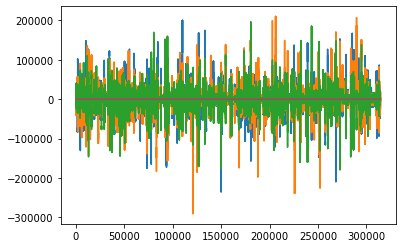

X: (314601, 6) Y: (314601, 6)
xtrain: (267410, 6) ytrian: (267410, 6)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               700       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 4,130
Trainable params: 4,130
Non-trainable params: 0
_________________________________________________________________


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

In [65]:
X, Y = X, y

plt.plot(Y)
plt.show()

print("X:", X.shape, "Y:", Y.shape)
in_dim = X.shape[1]
out_dim = Y.shape[1]

xtrain, xtest, ytrain, ytest=train_test_split(X, Y, test_size=0.15)
print("xtrain:", xtrain.shape, "ytrian:", ytrain.shape)

model = Sequential()
model.add(Dense(100, input_dim=in_dim, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(out_dim))
model.compile(loss="mse", optimizer="adam")
model.summary()
 
model.fit(xtrain, ytrain, epochs=100, batch_size=12, verbose=0)
 
ypred = model.predict(xtest)
for i in range(6):
    print(f"y_{i} MSE:%.4f" % mean_squared_error(ytest[:,i], ypred[:,i]))

x_ax = range(len(xtest))
plt.figure()
for i in range(6):
    plt.scatter(x_ax, ytest[:,i],  s=6, label=f"y{i}-test")
    plt.plot(x_ax, ypred[:,i], label=f"y{i}-pred")
plt.legend()
plt.show()

